### Libraries

In [1]:
import os
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import pandas as pd
import numpy as np
import shutil
from sklearn.model_selection import train_test_split
from mtcnn import MTCNN

### Constants

In [2]:
dataset_path = "/Users/uvaishnav/Downloads/archive/Original Images/Original Images"
extracted_faces_path = "./artifacts/extracted_faces"

In [3]:
train_dir = os.path.join(extracted_faces_path,"train")
test_dir = os.path.join(extracted_faces_path,"test")
validation_dir = os.path.join(extracted_faces_path,"validation")

In [4]:
detector = MTCNN()

## Understanding Our Dataset

In [5]:
classes = os.listdir(dataset_path)
num_classes = len(classes)
print("There are {} faces in this dataset".format(num_classes))
# print(classes)

There are 32 faces in this dataset


### Understanding the distribution

In [6]:
data = []

for each_class in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, each_class)
    if os.path.isdir(class_path):
        num_images = len([file for file in os.listdir(class_path) if file.endswith(('jpg', 'jpeg', 'png'))])
        data.append([each_class, num_images])

distribution = pd.DataFrame(data, columns=['Class Name', 'Number of Images'])


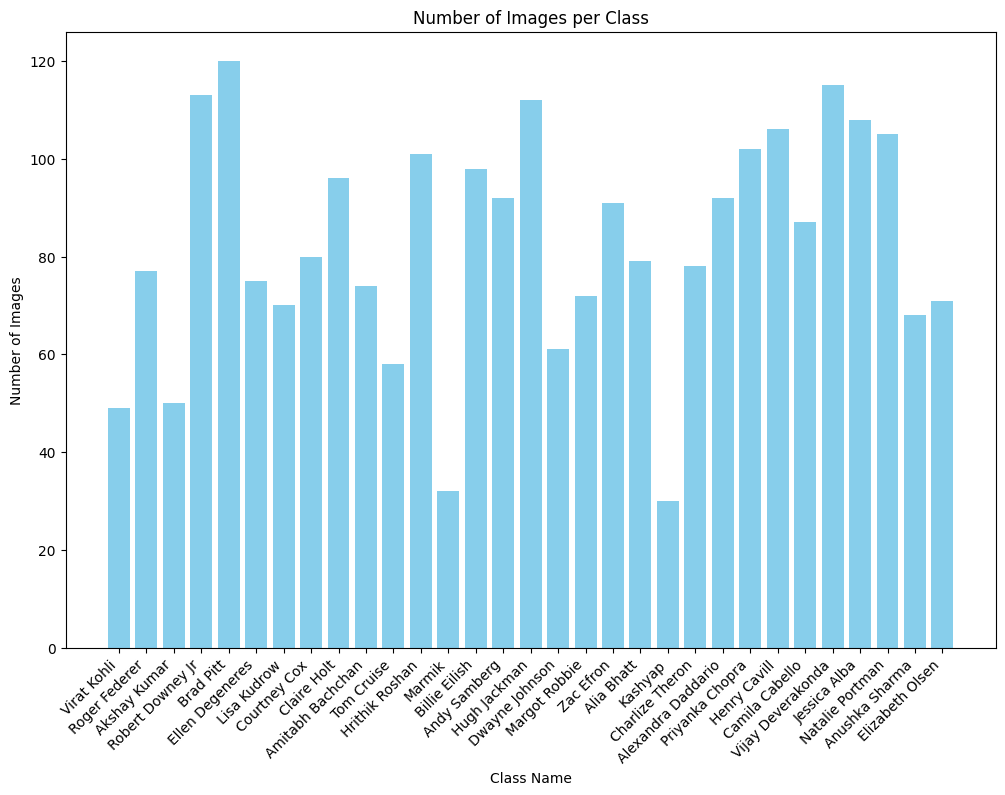

In [7]:
plt.figure(figsize=(12, 8))
plt.bar(distribution['Class Name'], distribution['Number of Images'], color='skyblue')
plt.xlabel('Class Name')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class')
plt.xticks(rotation=45, ha='right')
plt.show()

### Inference 1
- Based on the above bar graph we can observe that there are more than 120 images for some people and less than 40 images for some people.
- This shows that the dataset is imbalenced
- We have to apply augmentation further, before using these images for training

### Inspecting the Data

In [8]:
def display_sample_images(data, num_classes=5, num_images=5):
    classes = os.listdir(data)[:num_classes]
    plt.figure(figsize=(20, 20))
    for i,each_class in enumerate(classes):
        class_path = os.path.join(data,each_class)
        images = os.listdir(class_path)
        for j in range(num_images):
            img_path = os.path.join(class_path,images[j])
            img = Image.open(img_path)
            plt.subplot(num_classes, num_images, i*num_images + j + 1)
            plt.imshow(img)
            plt.title(f"{each_class} - Image {j+1}")
            plt.axis('off')
    plt.show()


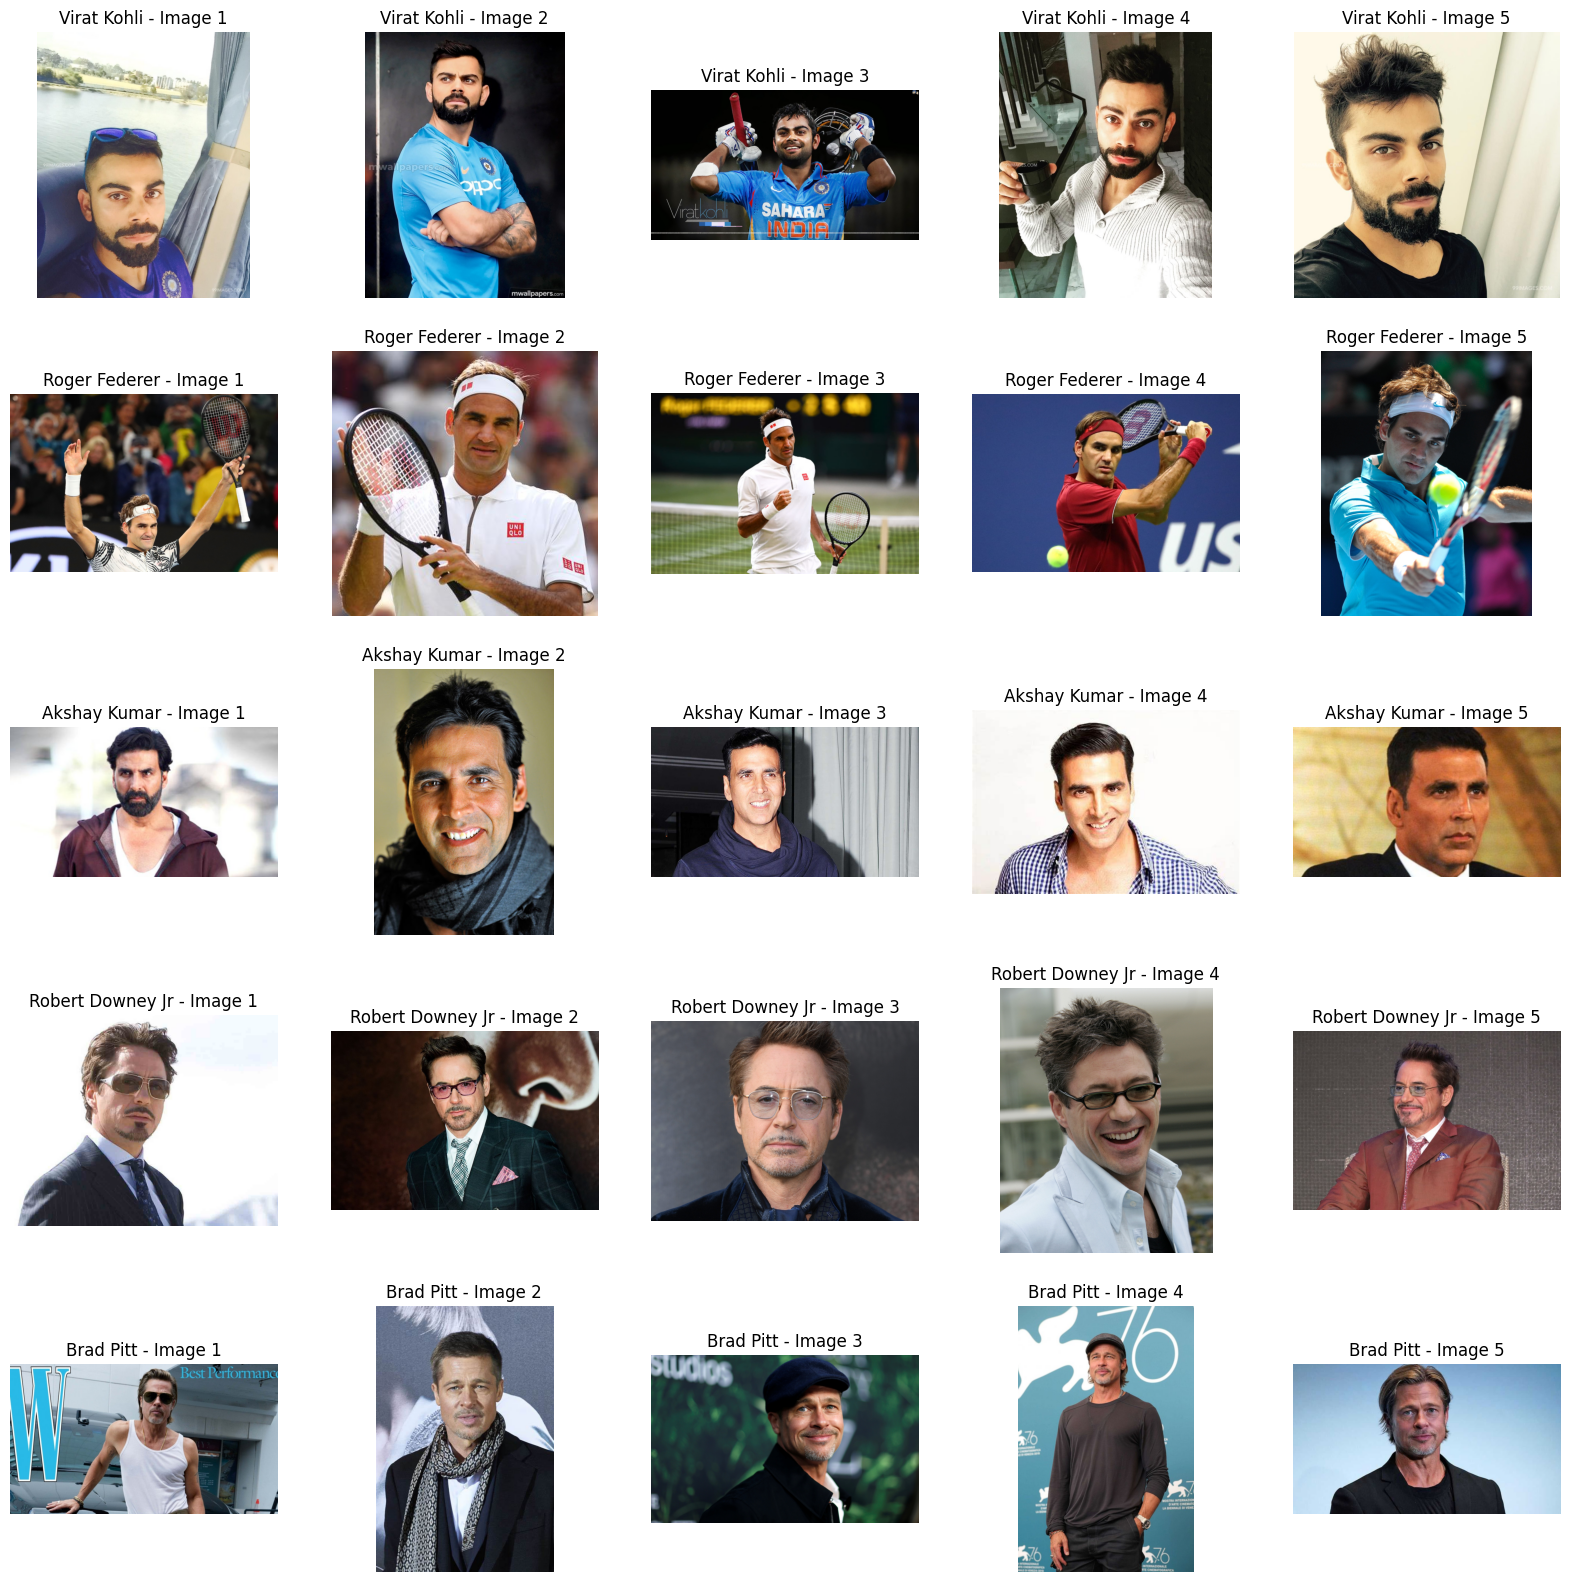

In [9]:
display_sample_images(dataset_path)

### Inference 2
- We can observe images in the dataset are with complex background and dressing styles which might impact the models performance.
- So we need to extract the face in each image and use it for training

## Extracting faces from image and spliting into train, test, validation split

### Extract faces 

In [ ]:
for person in os.listdir(dataset_path):
    person_path = os.path.join(dataset_path,person)
    if os.path.isdir(person_path):
        for img_file in os.listdir(person_path):
            img_path = os.path.join(person_path,img_file)
            img = Image.open(img_path)

            ## Extract faces
            faces = detector.detect_faces(np.array(img))
            for i, face in enumerate(faces):
                x, y, width, height = face["box"]
                face_img = img.crop((x, y, x+width, y+height))

                # Save path
                person_output_dir = os.path.join(extracted_faces_path,person)
                os.makedirs(person_output_dir, exist_ok=True)
                face_output_path = os.path.join(person_output_dir,f"{img_file.split('.')[0]}_face{i+1}.jpg")

                face_img.save(face_output_path)


### Split dataset into train, test, and validatioin

In [13]:
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

In [14]:
def move_images(src_dir, dst_dir, person, images):
    for img in images:
        src = os.path.join(src_dir, img)
        dst = os.path.join(dst_dir, person, img)
        os.makedirs(os.path.join(dst_dir, person), exist_ok=True)
        shutil.move(src, dst)

In [15]:
def split_and_move_images(output_dir, train_dir, test_dir, validation_dir):
    for person in os.listdir(output_dir):
        person_path = os.path.join(output_dir, person)
        if os.path.isdir(person_path) and person not in ["train", "test", "validation"]:
            images = os.listdir(person_path)
            train_imgs, test_val_imgs = train_test_split(images, test_size=0.2, random_state=42)
            test_imgs, val_imgs = train_test_split(test_val_imgs, test_size=0.5, random_state=42)

            move_images(person_path, train_dir, person, train_imgs)
            move_images(person_path, test_dir, person, test_imgs)
            move_images(person_path, validation_dir, person, val_imgs)


In [16]:
split_and_move_images(extracted_faces_path, train_dir, test_dir, validation_dir)

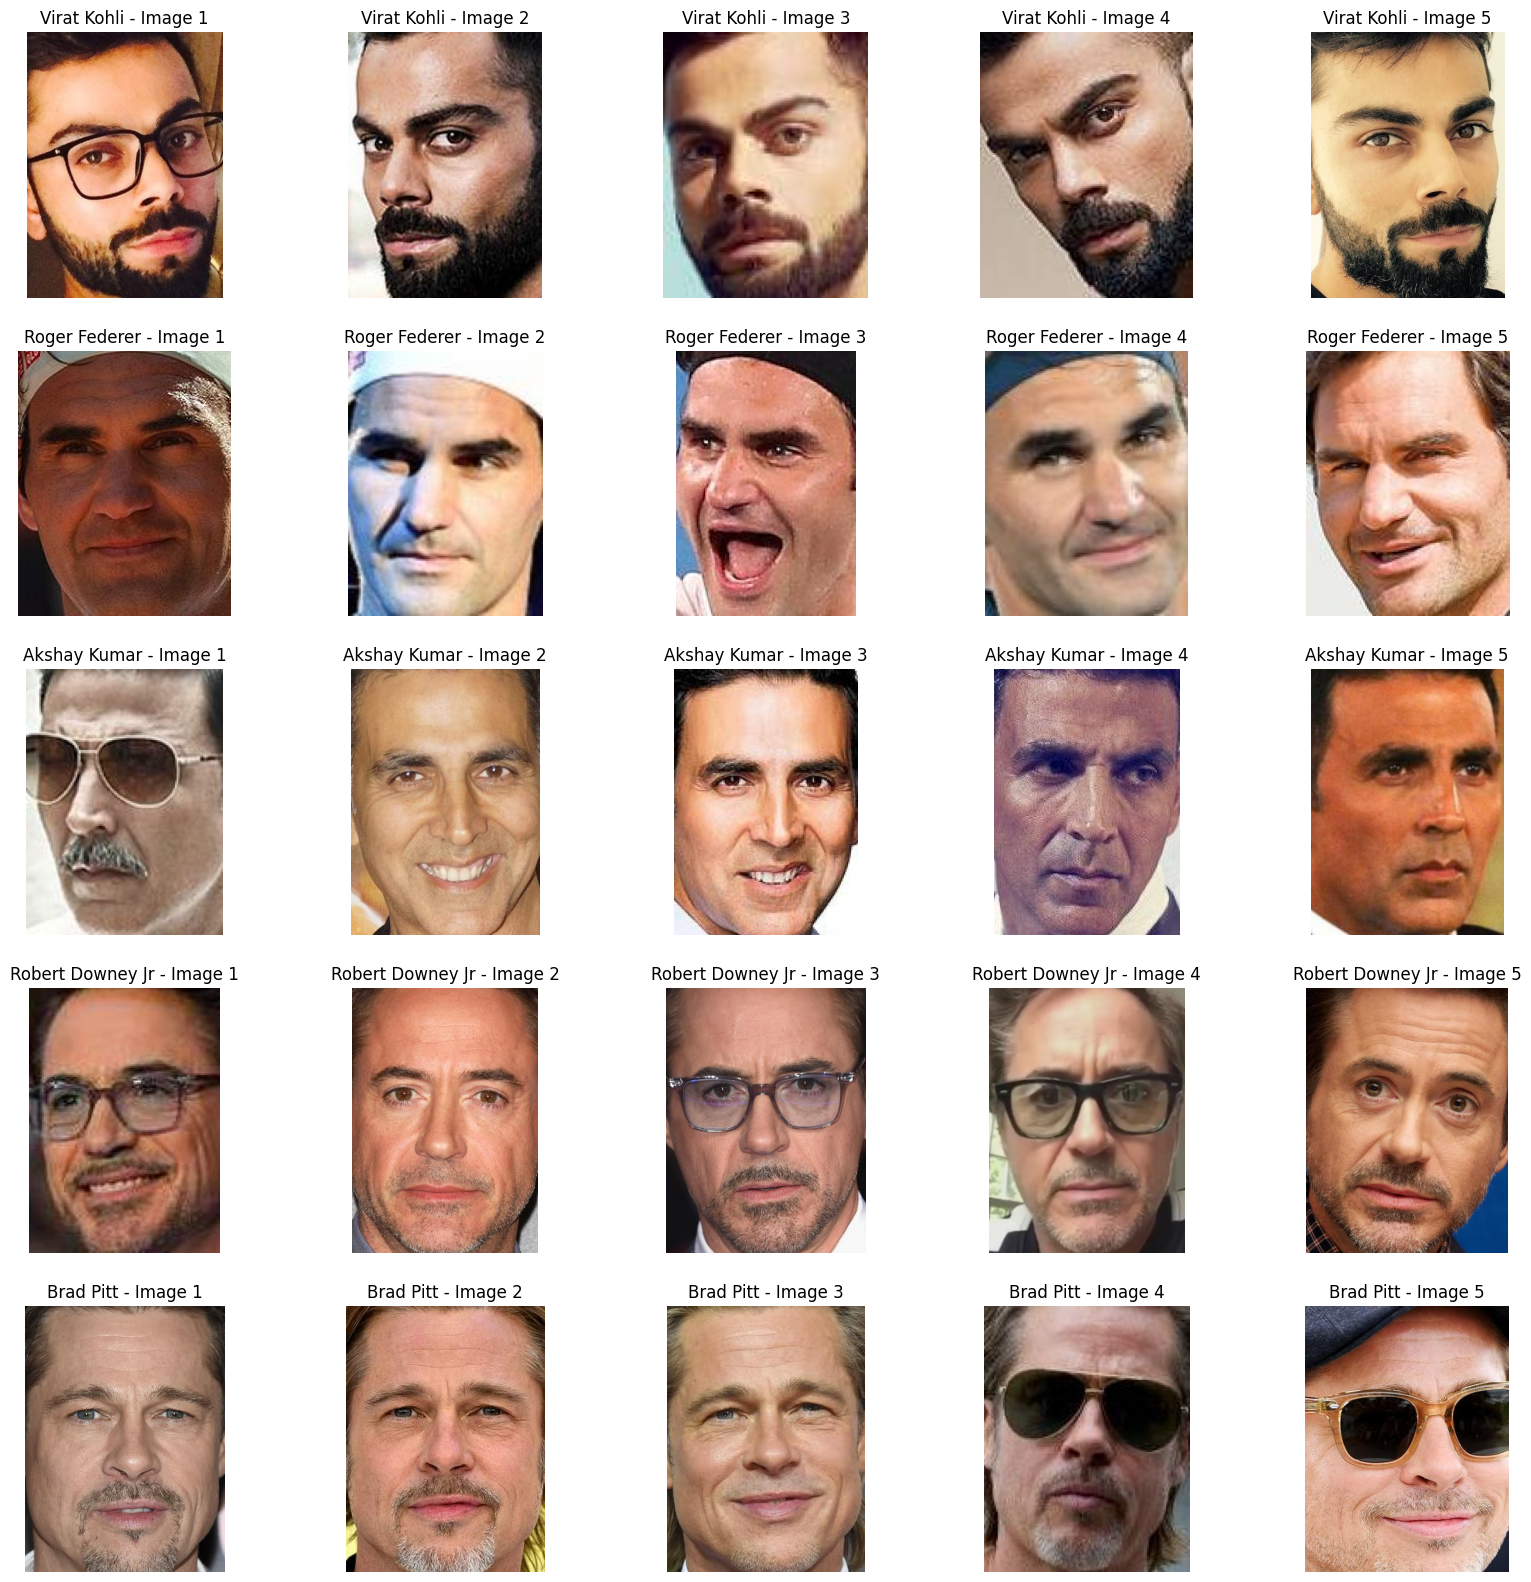

In [22]:
display_sample_images(train_dir)

### Inference 3

Now we have extracted faces and we can use them for training